Gaussian Process Interactive
-----------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 25
rcParams['figure.figsize'] = [13,7]
from itertools import product

Kernel Functions
-----------------------

In [2]:
def m0(x):
    return np.zeros([x.shape[0],1])

def se_kernel(Xa, Xb, args):
    K = np.zeros([Xa.shape[0], Xb.shape[0]])
    for i, Xa_i in enumerate(Xa):
        for j, Xb_j in enumerate(Xb):
            K[i,j] = args['sigma']**2 * np.exp(-1./(2*(args['l']**2)) * np.inner(Xa_i - Xb_j, Xa_i - Xb_j))
    return K

def rq_kernel(Xa, Xb, args):
    K = np.zeros([Xa.shape[0], Xb.shape[0]])
    for i, Xa_i in enumerate(Xa):
        for j, Xb_j in enumerate(Xb):
            K[i,j] = args['sigma']**2 * (1 + np.inner(Xa_i - Xb_j, Xa_i - Xb_j) / 
                                         (2. * args['alpha'] * args['l']**2)) ** (-args['alpha'])
    return K

def lin_kernel(Xa, Xb, args):
    K = np.zeros([Xa.shape[0], Xb.shape[0]])
    for i, Xa_i in enumerate(Xa):
        for j, Xb_j in enumerate(Xb):
            K[i, j] = args['sigma_b']**2 + args['sigma_v']**2 * np.inner(Xa_i - args['c'], Xb_j - args['c'])
    return K

def per_kernel(Xa, Xb, args):
    K = np.zeros([Xa.shape[0], Xb.shape[0]])
    for i, Xa_i in enumerate(Xa):
        for j, Xb_j in enumerate(Xb):
            K[i, j] = args['sigma']**2 * np.exp(-2 * np.sin(np.pi * np.inner(Xa_i - Xb_j, Xa_i - Xb_j) / args['p'])**2)
    return K

### Gaussian process class functions

In [3]:
class GP:   
   
    def __init__(self, meanfun='m0', kernel='se', kernelargs={'l':.1, 'sigma':.1}, noise_sigma=0):
        if meanfun=='m0':
            self.m = m0
        else:
            raise NotImplementedError('This mean function is not implemented.')
        
        if kernel=='se':
            self.k = se_kernel
        elif kernel=='rq':
            self.k = rq_kernel
        elif kernel == 'per':
            self.k = per_kernel
        elif kernel == 'lin':
            self.k = lin_kernel
        else:
            raise NotImplementedError('This kernel function is not implemented.')
            
        self.kernelargs = kernelargs
        self.noise_sigma = noise_sigma
                                      
    def fit(self, X, f):
        assert(X.shape[0]==f.shape[0])
        self.X = X
        self.f = f
    
    def predict(self, Xstar):
        K = self.k(self.X, self.X, self.kernelargs) + self.noise_sigma * np.identity(self.X.shape[0])
        Kinv = np.linalg.inv(K)
        Kstar = self.k(self.X, Xstar, self.kernelargs)
        Kstarstar = self.k(Xstar, Xstar, self.kernelargs)
        mustar = self.m(Xstar) + np.dot(np.dot(Kstar.T,Kinv), (self.f-self.m(self.X)))
        Sigmastar = Kstarstar - np.dot(np.dot(Kstar.T,Kinv),Kstar)
        return mustar, Sigmastar
    
    def plot(self, Xstar, fstar, fstarstd):
        upper = fstar-2*np.sqrt(np.diag(fstarstd))[:,np.newaxis]
        lower = fstar+2*np.sqrt(np.diag(fstarstd))[:,np.newaxis]
        plt.fill_between(np.squeeze(Xstar),np.squeeze(lower), np.squeeze(upper), color='.9', alpha=.5)
        plt.plot(Xstar,fstar, 'k', linewidth=3.)
        plt.scatter(self.X, self.f, c='k', marker='o', s=100)
        plt.xlim([min(Xstar), max(Xstar)])
        
    def plot_expectation(self, Xstar, **kwargs):
        fstar, fstarstd = self.predict(Xstar)
        plt.plot(Xstar, fstar, **kwargs)
        
    def plot_predict(self, Xstar):
        fstar, fstarstd = self.predict(Xstar)
        self.plot(Xstar, fstar, fstarstd)      
        
    def plot_prior(self, Xstar, N_lines=1, plot_lines = True, plot_expectation=True, plot_funmean=True, plot_std=True, plot_funstd = False):
        mu = np.squeeze(self.m(Xstar))
        Sigma = self.k(Xstar, Xstar, self.kernelargs)
        kk = np.sqrt(np.diag(Sigma))
        if plot_std:
            plt.fill_between(Xstar, mu-2*kk, mu+2*kk, color='.9')
        MVN = np.random.multivariate_normal(mu, Sigma, N_lines)
        if plot_lines:
            plt.plot(Xstar,MVN.T) #, label='samples from the prior')
        if plot_expectation:
            plt.plot(Xstar, mu, color='.4', linewidth=5., alpha=.5)
        if plot_funmean:
            plt.plot(Xstar,MVN.mean(axis=0), color='k', linewidth=5., alpha=.8) #, label='mean of samples (other colors) drawn from the GP prior')
        if plot_funstd:
            fstd = MVN.std(axis=0)
            plt.fill_between(Xstar, mu-2*fstd, mu+2*fstd, color='pink', alpha=.3)
        plt.xlim([min(Xstar),max(Xstar)])
    
    def plot_posterior(self, Xstar, N_lines=1, plot_lines = True, plot_expectation=True, plot_funmean=True, plot_std=True, plot_funstd = False):
        mustar, Sigmastar = self.predict(Xstar)
        if plot_std:
            kk = np.sqrt(np.diag(Sigmastar))
            plt.fill_between(Xstar, np.squeeze(mustar)-2*kk, np.squeeze(mustar)+2*kk, color='.9')
        MVN = np.random.multivariate_normal(np.squeeze(mustar), Sigmastar, N_lines)
        if plot_lines:
            plt.plot(Xstar, MVN.T)
        if plot_expectation:
            plt.plot(Xstar, mustar, color='.4', linewidth=5., alpha=.5)
        if plot_funmean:
            plt.plot(Xstar,MVN.mean(axis=0), color='k', linewidth=5., alpha=.8)
        if plot_funstd:
            fstd = MVN.std(axis=0)
            plt.fill_between(Xstar, mu-2*fstd, mu+2*fstd, color='pink', alpha=.3)
        plt.xlim([min(Xstar), max(Xstar)])

### Plotting options

In [4]:
def set_plotting_options(plt, xlim, ylim, xlabel='$x$', ylabel='$f(x)$'):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)

Example
-------

In [5]:
# create data
t = np.array([0, .1, 0.2, .3,.6, 1., 1.1, 1.5, 1.9, 2.0])[:, np.newaxis]
ft = np.array([1, 10, 14, 16, 15, 8, 7, 4, 3, 3])[:, np.newaxis]
ft = ft - np.mean(ft)
xlim = [-.1,4.]
ylim = [-10, 12]

tstar = np.arange(xlim[0], xlim[1], .01)

Plot the points
-------

/home/vishal/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


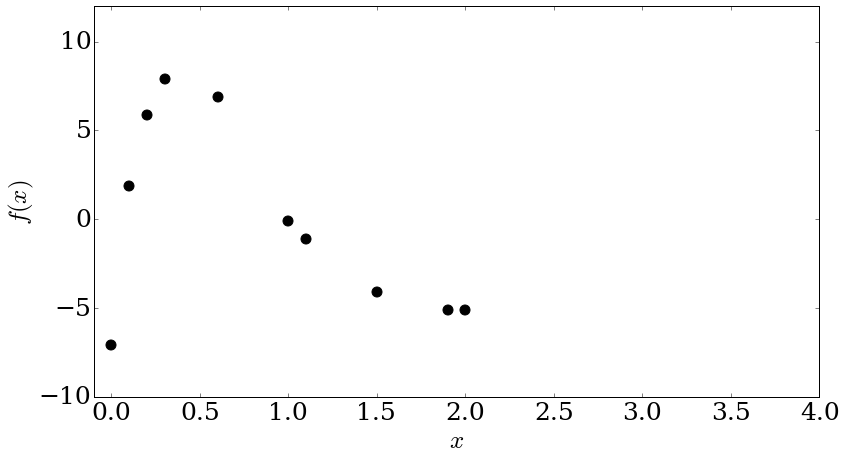

In [6]:
plt.scatter(t, ft, c='k', marker='o', s=100)
set_plotting_options(plt, xlim, ylim)

### Generate a Gaussian Process - Using different type of Kernels

In [7]:
#gp = GP(kernel='lin', kernelargs={'sigma_v': .5, 'sigma_b': .5, 'c': 2}, noise_sigma=.1)
#gp = GP(kernel='se', kernelargs={'l': .0002, 'sigma': 5.}, noise_sigma=10.) 
#gp = GP(kernel='rq', kernelargs={'l':.2, 'sigma':2.5, 'alpha': 1., 'noise_sigma': 1.}) 
gp = GP(kernel='per', kernelargs={'l':1., 'sigma':2.5, 'p': 0.05}) 
gp.fit(t, ft)